In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import numpy as np
import glob
import matplotlib.pyplot as plt
import MeCab

from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# ファイルの一覧を取得
files = glob.glob("data/*/*.txt")
print (files[:10]) # 最初の10件表示

['data/livedoor-homme/livedoor-homme-4608109.txt', 'data/livedoor-homme/livedoor-homme-5695247.txt', 'data/livedoor-homme/livedoor-homme-4768050.txt', 'data/livedoor-homme/livedoor-homme-5608639.txt', 'data/livedoor-homme/livedoor-homme-5460086.txt', 'data/livedoor-homme/livedoor-homme-5695257.txt', 'data/livedoor-homme/livedoor-homme-5442194.txt', 'data/livedoor-homme/livedoor-homme-6403291.txt', 'data/livedoor-homme/livedoor-homme-6393628.txt', 'data/livedoor-homme/livedoor-homme-4883137.txt']


In [3]:
# 全ファイルをロード
# ついでに正解クラスと対応付け
X_texts = []
y = []
category_dict = {}
for file_path in files:
    class_name = file_path.split("/")[-2]
    y.append(category_dict.setdefault(class_name, len(category_dict)))
    with open(file_path, "r") as f:
        text = ""
        for line in f:
            text += line
    X_texts.append(text)

In [4]:
# ボキャブラリ辞書の作成とIDFの計算を行う
# 名詞のみを使う
mt = MeCab.Tagger("-Ochasen")
'''
def make_vocab(texts, freq=10):
    """
    辞書を作成する
    texts:辞書を作るためのテキストのリスト
    freq:出現回数での足切りのための閾値
    """
    all_vocab = {}   # 全ての単語用辞書
    all_counter = {} # 出現回数カウンタ(全ての単語用)
    for text in texts:
        lines = text.split("\n")
        for i, line in enumerate(lines):
            if i <= 2: continue # 1,2行目はメタ情報っぽいので除く
            mt.parse('')  # 文字コードの闇回避用
            res = mt.parseToNode(line)
            while res:
                infos = res.feature.split(",")
                if infos[0] == "名詞":
                    all_vocab.setdefault(res.surface, len(all_vocab))
                    all_counter[res.surface] = all_counter.get(res.surface, 0) + 1
                res = res.next

    # 出現回数freq回の単語のみ出力
    # df のために総単語出現数Nをカウント
    vocab = {}   # 最終的な辞書
    N = 0
    idx = 0
    for k,v in all_vocab.items():
        if all_counter[k] >= freq:
            vocab[k] = idx
            N += all_counter[k]
            idx += 1
    
    # idfを計算
    idf = {}
    for k,v in vocab.items():
        idf[v] = math.log(N/all_counter[k] + 1)
    
    return vocab, idf
'''
# bow用の辞書を作成する
# 名詞のみを使う
mt = MeCab.Tagger("-Ochasen")
def make_vocab(texts, freq=10):
    """
    辞書を作成する
    texts:辞書を作るためのテキストのリスト
    freq:出現回数での足切りのための閾値
    """
    all_vocab = {} # 全ての単語用辞書
    vocab = {} # 最終的な辞書
    counter = {} # 出現回数カウント用
    for text in texts:
        lines = text.split("\n")
        for i, line in enumerate(lines):
            if i <= 2: continue # 1,2行目はメタ情報っぽいので除く
            mt.parse('')  # 文字コードの闇回避用
            res = mt.parseToNode(line)
            while res:
                infos = res.feature.split(",")
                if infos[0] == "名詞":
                    all_vocab.setdefault(res.surface, len(all_vocab))
                    counter[res.surface] = counter.get(res.surface, 0) + 1
                res = res.next

    idx = 0
    N = 0
    for k,v in all_vocab.items():
        if counter[k] >= freq:
            vocab[k] = idx
            N += counter[k]
            idx += 1
    
    # idfを計算
    idf = {}
    for k,v in vocab.items():
        idf[v] = math.log(N/counter[k] + 1)
    
    return vocab, idf

In [5]:
def make_bow(text, vocab):
    """
    文章をbow形式に変換
    text:bow形式に変換したいテキスト
    vocab:使う単語をまとめた辞書
    """
    bow = [0 for _ in range(len(vocab))]
    lines = text.split("\n")
    for line in lines:
        res = mt.parseToNode(line)
        while res:  
            index = vocab.get(res.surface, -1)
            if index >= 0:
                bow[index] += 1
            res = res.next
            
    return bow

In [6]:
def make_tfidf(text, vocab, idf):
    """
    文章をtfidf特徴量形式に変換
    text:tfidf特徴量形式に変換したいテキスト
    vocab:使う単語をまとめた辞書
    idf:vocabのidfをまとめた辞書
    """
    tfidf = [0 for _ in range(len(vocab))] # listの初期化
    lines = text.split("\n")
    
    # tfをカウント
    # 同時に文書内の名詞の総出現数をカウント
    doc_N = 0     # 文書内の名詞の総数
    words = set() # 出現した単語を保存
    for line in lines:
        res = mt.parseToNode(line)
        while res:
            infos = res.feature.split(",")
            if infos[0] == "名詞":
                doc_N += 1
                index = vocab.get(res.surface, -1)
                if index >= 0:
                    tfidf[index] += 1
                    words.add(index) # インデックスを登録しておく
            res = res.next
    
    #print (tfidf)
    # tfidfを計算
    for word_index in words:
        tfidf[word_index] *= idf[word_index] / doc_N
    
    return tfidf

In [7]:
vocab, idf = make_vocab(X_texts)

In [ ]:
make_tfidf(X_texts[0] ,vocab, idf)

In [8]:
X = []
for texts in X_texts:
    X.append(make_tfidf(texts, vocab, idf))
    #X.append(make_bow(texts, vocab))

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X)

print tfidf.toarray()

[[ 0.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.    0.01 ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.  ]]


In [16]:
#X = np.asarray(X)
X = np.asarray(tfidf.toarray())
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [11]:
classifier = svm.SVC(kernel='linear', C=0.03)
y_pred = classifier.fit(X_train, y_train).predict(X_test)
print (y_pred)

[7 8 7 ..., 1 4 4]


In [17]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=50)
y_pred= model.fit(X_train, y_train).predict(X_test)

In [12]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(category_dict))
    plt.xticks(tick_marks, category_dict, rotation=45)
    plt.yticks(tick_marks, category_dict)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 76   8   2   0   5  24   1   9   8]
 [  0 207   0   0   0   2   4   0   0]
 [  0   3 209   0   1   2   1   1   8]
 [  0   0   0 207   0   1   0   0   0]
 [  0   2   0   0 206   1   1   4   0]
 [  1   3   5   0   4 184   1  14   1]
 [  0   8   3   0   2   0 183   0   0]
 [  0   1   0   0   3  13   0 205   1]
 [  1   1   5   1   4   2   1   1 203]]


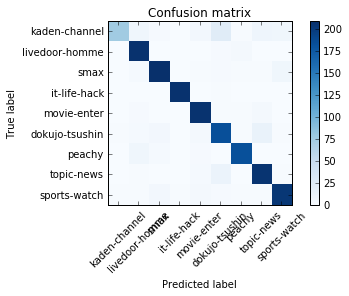

In [18]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

In [ ]:
X[0].sum()

Normalized confusion matrix
[[ 0.57  0.06  0.02  0.    0.04  0.18  0.01  0.07  0.06]
 [ 0.    0.97  0.    0.    0.    0.01  0.02  0.    0.  ]
 [ 0.    0.01  0.93  0.    0.    0.01  0.    0.    0.04]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.    0.    0.96  0.    0.    0.02  0.  ]
 [ 0.    0.01  0.02  0.    0.02  0.86  0.    0.07  0.  ]
 [ 0.    0.04  0.02  0.    0.01  0.    0.93  0.    0.  ]
 [ 0.    0.    0.    0.    0.01  0.06  0.    0.92  0.  ]
 [ 0.    0.    0.02  0.    0.02  0.01  0.    0.    0.93]]


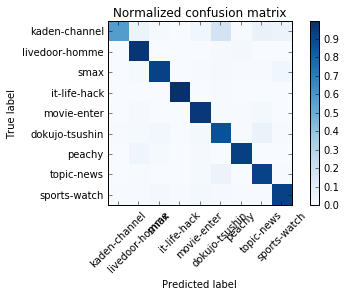

In [19]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()